In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Mount Google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
csv_file_path = "/content/drive/MyDrive/investigator_nacc63.csv"
df = pd.read_csv(csv_file_path)

<ipython-input-45-2cb18483d381>:3: DtypeWarning:

Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
# Display the first few rows of the dataset
print(df.head())

       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
1  NACC004352      186      I      3.0       10         5     2021         1   
2  NACC004687      186      I      3.0       11        14     2022         1   
3  NACC008514      186      I      3.0       11        15     2022         1   
4  NACC013667      186      I      3.0        3        29     2022         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         1         1  ...        -4        -4        -4        -4        -4   
1         1         1  ...        -4        -4        -4        -4        -4   
2         1         1  ...        -4        -4        -4        -4        -4   
3         1         1  ...        -4        -4        -4        -4        -4   
4         1         1  ...        -4        -4        -4        -4        -4   

   NPATGFRN  NPATGFR1  NPATGFR2  NPATG

In [ ]:
# Display basic information about the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183097 entries, 0 to 183096
Columns: 1024 entries, NACCID to NPATGFR4
dtypes: float64(134), int64(748), object(142)
memory usage: 1.4+ GB
None


In [ ]:
# Display summary statistics
print(df.describe())

             NACCADC        FORMVER        VISITMO       VISITDAY  \
count  183097.000000  183097.000000  183097.000000  183097.000000   
mean     5045.374386       2.313191       6.364457      15.427145   
std      2963.788303       0.699132       3.394358       8.603537   
min       186.000000       1.000000       1.000000       1.000000   
25%      2289.000000       2.000000       3.000000       8.000000   
50%      5310.000000       2.000000       6.000000      15.000000   
75%      8361.000000       3.000000       9.000000      23.000000   
max      9661.000000       3.200000      12.000000      31.000000   

             VISITYR       NACCVNUM       NACCAVST       NACCNVST  \
count  183097.000000  183097.000000  183097.000000  183097.000000   
mean     2013.810385       3.762399       6.524798       5.693059   
std         4.992962       3.005342       4.086922       3.837000   
min      2005.000000       1.000000       1.000000       1.000000   
25%      2010.000000       1.0000

In [ ]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 NACCID      0
NACCADC     0
PACKET      0
FORMVER     0
VISITMO     0
           ..
NPATGFRN    0
NPATGFR1    0
NPATGFR2    0
NPATGFR3    0
NPATGFR4    0
Length: 1024, dtype: int64


In [ ]:
# Assuming 'BIRTHYR' is the column you want to extract values from
birthyr_column = 'BIRTHYR'

In [ ]:
# Display the first 10 values of the 'BIRTHYR' column
first_10_values = df[birthyr_column].head(10)
print(f'First 10 values of {birthyr_column} column:\n{first_10_values}')

First 10 values of BIRTHYR column:
0    1952
1    1958
2    1945
3    1936
4    1945
5    1952
6    1947
7    1938
8    1952
9    1958
Name: BIRTHYR, dtype: int64


In [ ]:
# Function for preprocessing
def preprocess_data(df):
    # Define the columns to keep
    columns_to_keep = ['BIRTHYR', 'SEX', 'NACCMMSE', 'CDRGLOB', 'NACCALZP', 'BOSTON', 'TRAILA', 'TRAILB',
                       'CSFTAU', 'TAUPETAD', 'AMYLCSF', 'AMYLPET', 'DIABET', 'AFIBRILL', 'HYPERT', 'HYPCHOL',
                       'VB12DEF', 'THYDIS', 'ANGIOPCI', 'NACCALZD', 'PENTAGON', 'BRNINJ', 'DEP', 'EPILEP',
                       'SCHIZOP', 'PTSDDX', 'OTHPSY', 'ALCDEM', 'IMPSUB', 'MEDS', 'NACCUDSD']

    # Create 'AGE' column convert birthyear 'BIRTHYR' column to 'AGE'
    current_year = pd.to_datetime('today').year
    df['AGE'] = current_year - df['BIRTHYR']
    df = df.drop(columns=['BIRTHYR'])

    # Update columns_to_keep after the conversion from 'BIRTHYR'
    columns_to_keep[columns_to_keep.index('BIRTHYR')] = 'AGE'

    # Identify and encode categorical columns
    object_columns = df.select_dtypes(include='object').columns
    for col in object_columns:
        if col != 'NACCUDSD':  # Excludes the target variable from label encoding
            df[col] = pd.factorize(df[col])[0]

    # Mapping for the target variable
    class_mapping = {1: 0, 2: 1, 3: 2, 4: 3}
    df['NACCUDSD'] = df['NACCUDSD'].map(class_mapping)


    # Scaling numerical features
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

    # Select the specified columns
    df = df[columns_to_keep]

    return df

# Perform preprocessing
df = preprocess_data(df)

# Display the first few rows of the preprocessed dataset
print(df.head())

# Assuming 'AGE' is the column you want to extract values from
age_column = 'AGE'

# Display the first 10 values of the 'AGE' column
first_10_values = df[age_column].head(10)
print(f'First 10 values of {age_column} column:\n{first_10_values}')

# Print the DataFrame after preprocessing
print(df.head())

   AGE  SEX  NACCMMSE  CDRGLOB  NACCALZP  BOSTON  TRAILA  TRAILB  CSFTAU  \
0   72    1        -4        0         1      -4      51      87       8   
1   66    2        -4        1         1      -4     150     996       8   
2   79    1        -4        0         8      -4      63     108       8   
3   88    1        -4        0         2      -4      71     300       8   
4   79    1        -4        1         1      -4      60     300       8   

   TAUPETAD  ...  BRNINJ  DEP  EPILEP  SCHIZOP  PTSDDX  OTHPSY  ALCDEM  \
0         8  ...       1    0       0        0       0       0       0   
1         8  ...       1    0       0        0       0       0       0   
2         8  ...       0    0       0        0       0       0       0   
3         8  ...       0    0       0        0       0       0       0   
4         8  ...       0    0       0        0       0       0       0   

   IMPSUB  MEDS  NACCUDSD  
0       0     0         2  
1       0     0         3  
2       0     

In [ ]:
input_size = len(df.columns) - 1  # Exclude the target variable

# **VISIUALISATION FUNCTIONS SECTION BEGINS**

In [ ]:
# function for tree map plotting
import plotly.express as px

def generate_treemap(df, column, labels=None, value_range=None):
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df = df[df[column].between(*value_range)]

    # Get unique categories/values from the specified column
    categories = df[column].unique()

    # Create a DataFrame for counting occurrences of each category
    count_df = pd.DataFrame(index=categories, columns=['Count'])

    # Fill the DataFrame with counts
    for category in categories:
        count_df.loc[category, 'Count'] = (df[column] == category).sum()

    # Reset the index for plotting
    count_df = count_df.reset_index()

    # Rename columns for better plot labels
    count_df.columns = ['Category', 'Count']

    # Create a treemap using plotly
    title = f'Distribution of {column} Categories'
    if value_range is not None:
        title += f' (Values between {value_range[0]} and {value_range[1]})'

    fig = px.treemap(count_df, path=['Category'], values='Count', title=title)

    # Show the interactive treemap
    fig.show()

In [ ]:
# function for scatter and 2D density plot
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_vs_column(df, x_column, y_column, plot_type='scatter', values_range=None, **kwargs):
    """
    Plot a column against another column and display correlation value.

    Parameters:
    - df: DataFrame
    - x_column: str, column name for the x-axis
    - y_column: str, column name for the y-axis
    - plot_type: str, 'scatter' or 'density', default is 'scatter'
    - values_range: tuple or list, range of values to include in the plot (optional)
    - **kwargs: additional keyword arguments for customization

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))

    if values_range:
        df_filtered = df[df[x_column].isin(values_range)]
    else:
        df_filtered = df

    if plot_type == 'scatter':
        sns.scatterplot(x=df_filtered[x_column], y=df_filtered[y_column], **kwargs)
        plt.title(f'Scatter Plot of {x_column} vs {y_column}')
    elif plot_type == 'density':
        sns.kdeplot(x=df_filtered[x_column], y=df_filtered[y_column], fill=True, cmap='viridis', levels=20, **kwargs)
        plt.title(f'2D Density Plot of {x_column} vs {y_column}')

    plt.xlabel(x_column)
    plt.ylabel(y_column)

    # Calculate and display correlation value
    correlation_coefficient = df_filtered[x_column].corr(df_filtered[y_column])
    plt.text(0.5, 0.95, f'Correlation: {correlation_coefficient:.2f}', horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

    plt.show()

In [ ]:
# Function for bar cahrt
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(df, column, title=None, xlabel=None, ylabel=None, hue=None, palette=None, custom_labels=None, show_legend=True):
    """
    Plot a bar chart for a specified column in the DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name for the bar chart
    - title: str, title of the plot (optional)
    - xlabel: str, label for the x-axis (optional)
    - ylabel: str, label for the y-axis (optional)
    - hue: str, column name for grouping (optional)
    - palette: list, custom color palette for bars (optional)
    - custom_labels: dict, custom labels for specific values in the column (optional)
    - show_legend: bool, whether to show the legend (default is True)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    if palette is None:
        palette = 'Set2'  # Default seaborn color palette

    sns.countplot(x=column, data=df, hue=hue, palette=palette)

    plt.title(title if title else f'Bar Chart for {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Count')

    if custom_labels:
        # Explicitly set the x-axis ticks at the center of each bar
        unique_values = df[column].unique()
        x_ticks_positions = range(len(unique_values))
        plt.xticks(x_ticks_positions, labels=[custom_labels.get(value, value) for value in unique_values])

    if show_legend and hue:
        # Modify legend labels to show both original values and custom labels
        legend_labels = [f"{value} ({custom_labels.get(value, value)})" for value in df[hue].unique()]
        plt.legend(title=hue, labels=legend_labels)

    plt.show()

In [ ]:
# Histogram plot function
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(df, column, title=None, xlabel=None, ylabel=None, color='blue', value_range=None, bins=20):
    """
    Plot a histogram for a specified column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name
    - title: str, plot title (optional)
    - xlabel: str, x-axis label (optional)
    - ylabel: str, y-axis label (optional)
    - color: str, color of the histogram bars (default is 'blue')
    - bins: int or sequence, number of bins or bin edges (default is 20)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Plot histogram using Seaborn
    sns.histplot(df[column], color=color, bins=bins)

    # Set plot title and labels
    plt.title(title if title else f'Histogram of {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Frequency')

    # Show the plot
    plt.show()

In [ ]:
# two column barchart comparison

import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(df, column1, column2, value_range=None, palette='Set2', legend_labels=None):
    """
    Plot the count distribution of two columns in the DataFrame.

    Parameters:
    - df: DataFrame
    - column1: str, column name for the x-axis
    - column2: str, column name for the hue (grouping)
    - value_range: tuple or list, range of values to include in the plot (optional)
    - palette: str or list, color palette for the plot (optional)
    - legend_labels: dict, custom labels for the legend (optional)

    Returns:
    - None
    """
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df_filtered = df[df[column1].between(*value_range)]
    else:
        df_filtered = df

    # Map numerical values to labels
    df_filtered[column2] = df_filtered[column2].map(legend_labels)

    # Count the occurrences of each combination of column1 and column2
    count_df = df_filtered.groupby([column2, column1]).size().reset_index(name='Count')

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=column1, y='Count', hue=column2, data=count_df, palette=palette)

    # Set plot title and labels
    plt.title(f'Number of {column2}s Across {column1} Scores')
    plt.xlabel(column1)
    plt.ylabel('Count')

    # Customize legend labels
    if legend_labels:
        plt.legend(title=column2, labels=legend_labels)

    # Show the plot
    plt.show()

# **VISUALISATION CALLS**

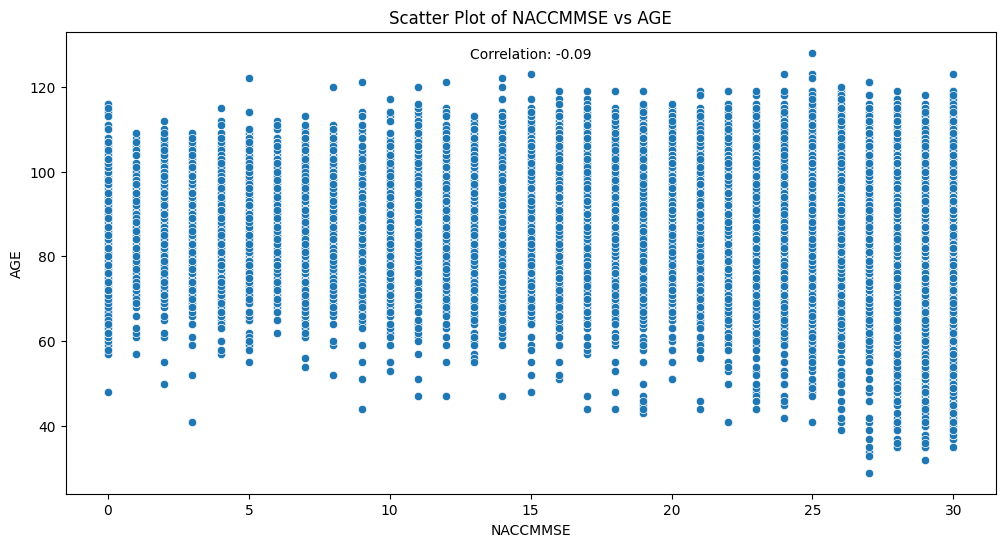

In [ ]:
# scatter plot for Age against MMSE score
plot_column_vs_column(df, 'NACCMMSE', 'AGE', plot_type='scatter', values_range=(range(31)))

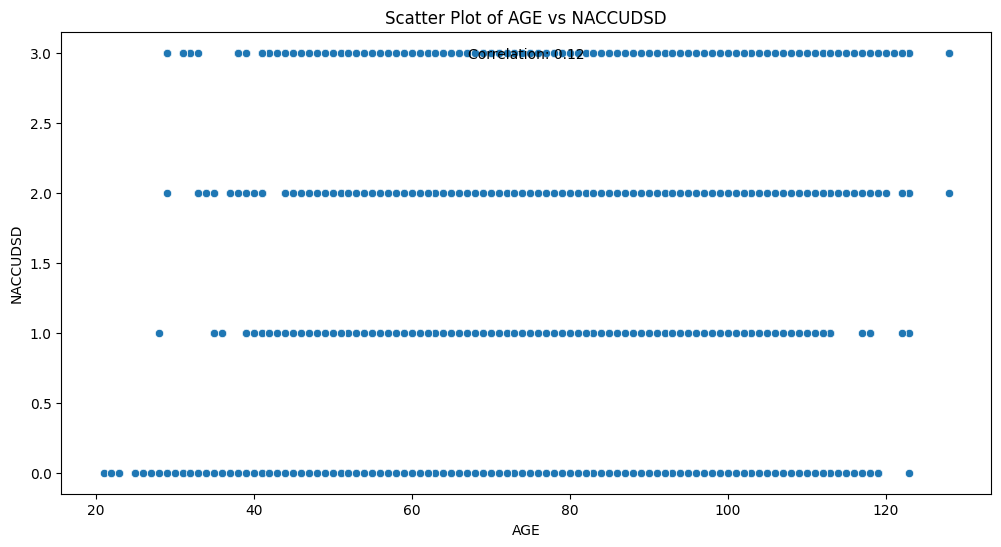

In [ ]:
# correlation scatter plot for AGE against target variable NACCUDSD
plot_column_vs_column(df, 'AGE', 'NACCUDSD', plot_type='scatter')

In [ ]:
# Treemap plot for Age distribution
generate_treemap(df, 'AGE')

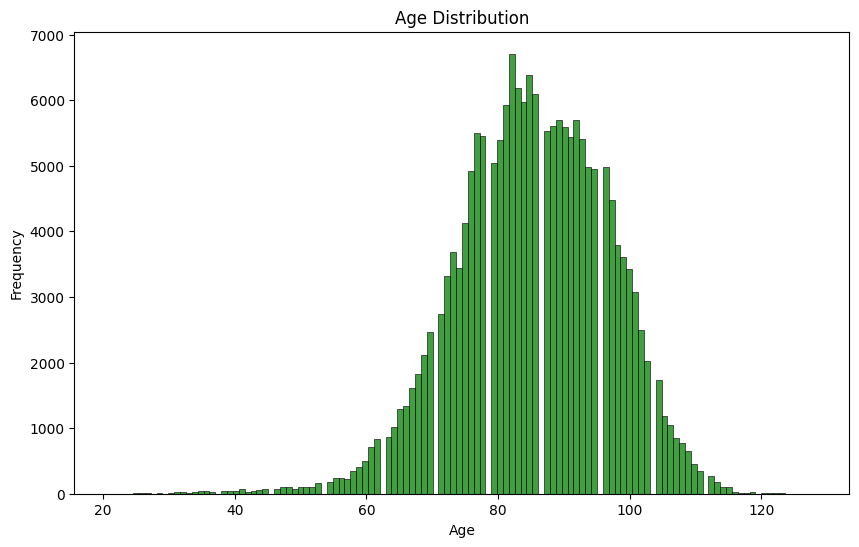

In [ ]:
# Histogram Plot for Age distribution
plot_histogram(df, 'AGE', title='Age Distribution', xlabel='Age', ylabel='Frequency', color='green', bins=120)

In [ ]:
# Distribution of all value in Total MMSE score 'NACCMMSE' column
generate_treemap(df, 'NACCMMSE')

In [ ]:
# Distribution of total MMSE score 'NACCMMSE' value 0 to 30 only
generate_treemap(df, 'NACCMMSE', value_range = (0,30))

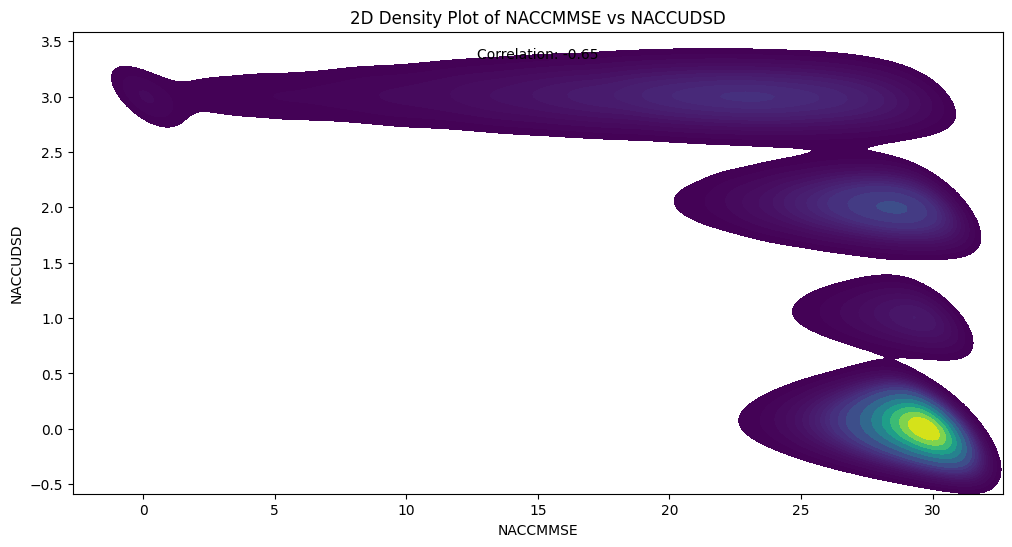

In [ ]:
# 2D density correlation plot for Total MMSE score against target ‘NACCUDSD’
plot_column_vs_column(df, 'NACCMMSE', 'NACCUDSD', plot_type='density', values_range=(range(31)))

<ipython-input-66-b40307a47f59>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



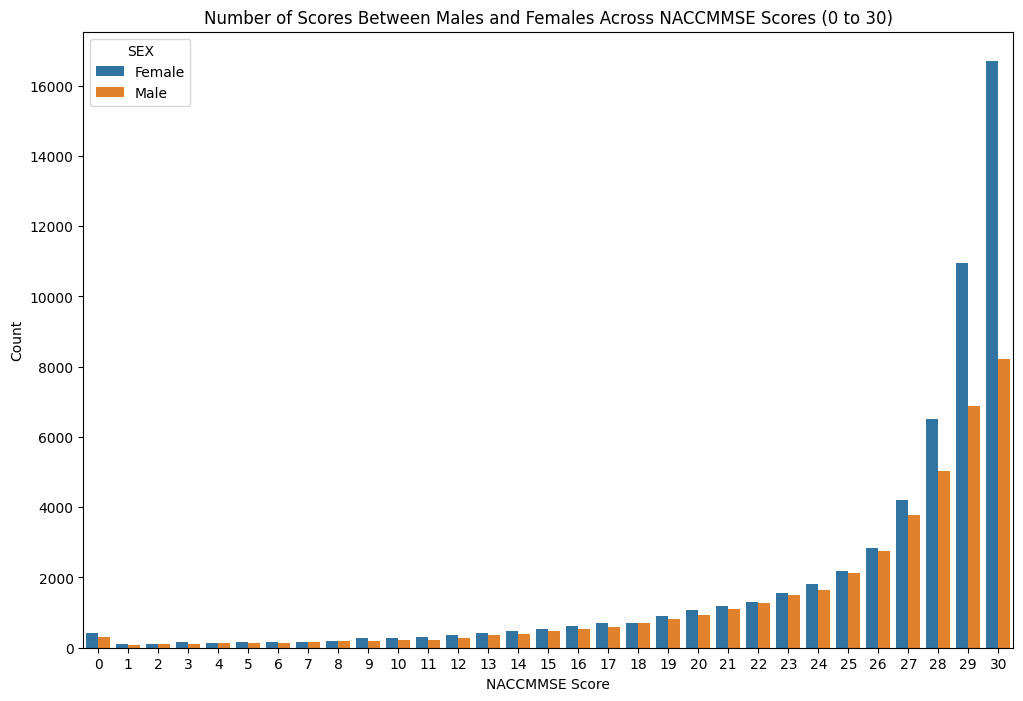

In [ ]:
# Histogram of the Total MMSE score 0 to 30 across gender
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for scores between 0 and 30
df_filtered = df[(df['NACCMMSE'] >= 0) & (df['NACCMMSE'] <= 30)]

# Map the numerical values in 'SEX' to labels
df_filtered['SEX'] = df_filtered['SEX'].map({1: 'Male', 2: 'Female'})

# Count the occurrences of each combination of 'SEX' and 'NACCMMSE'
score_counts = df_filtered.groupby(['SEX', 'NACCMMSE']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='NACCMMSE', y='Count', hue='SEX', data=score_counts)
plt.title('Number of Scores Between Males and Females Across NACCMMSE Scores (0 to 30)')
plt.xlabel('NACCMMSE Score')
plt.ylabel('Count')
plt.show()

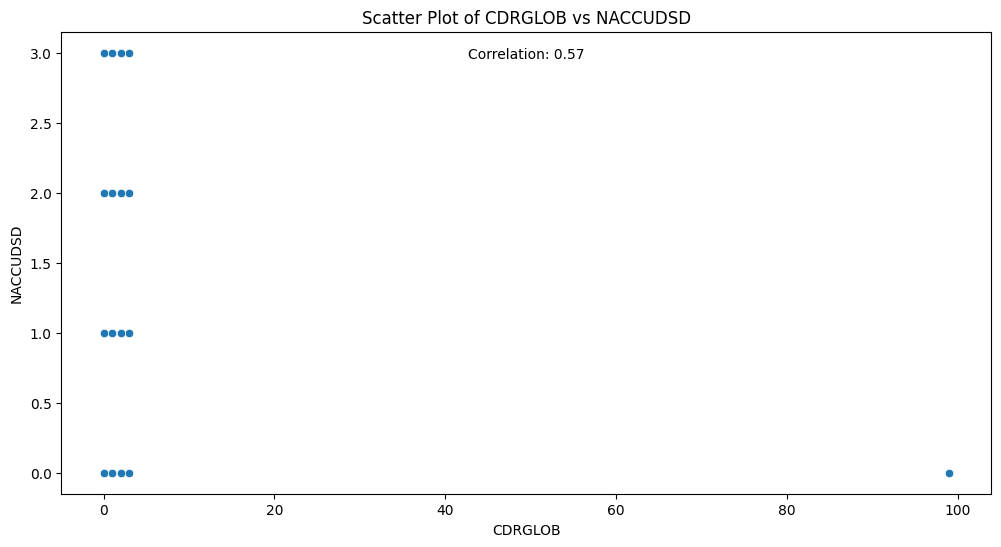

In [ ]:
# correlation scatter plot for CDRGLOB against target variable NACCUDSD
plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='scatter')

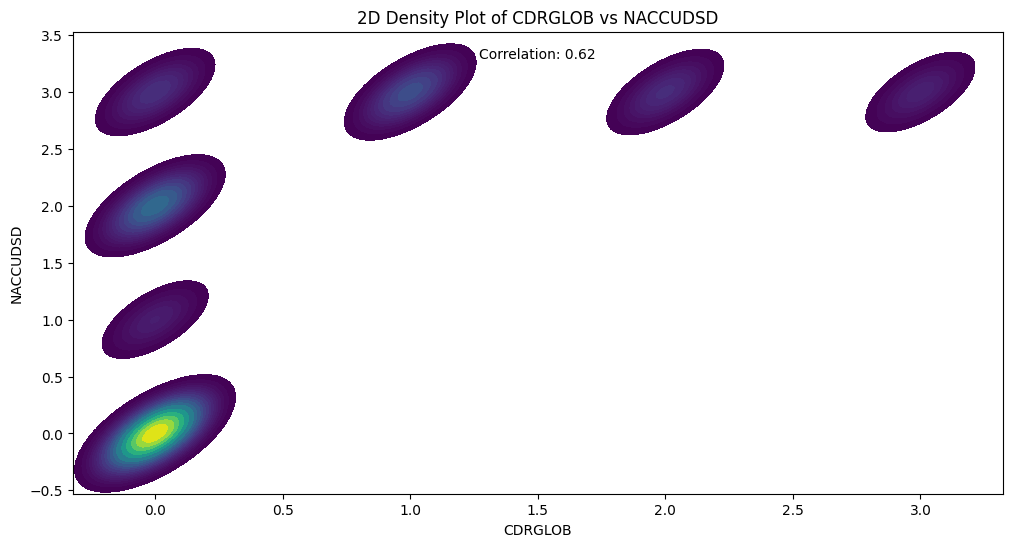

In [ ]:
#2D density plot for Global CDR 'CDRGLOB' score against target column 'NACCUDSD'
plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='density', values_range=(range(31)))

In [ ]:
# Check the distribution of the target variable
print("Class distribution:\n", df['NACCUDSD'].value_counts())

Class distribution:
 0    87792
3    55306
2    31914
1     8085
Name: NACCUDSD, dtype: int64


# **Class balancing of target variables, Data Split, Training and evaluation**

In [ ]:
# Split the data into features (X) and target variable (y)
X = df.drop('NACCUDSD', axis=1)
y = df['NACCUDSD']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# Define a custom dataset class
class AlzheimerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {'features': self.features[idx], 'label': self.labels[idx]}

# Create DataLoader instances for training and testing
batch_size = 64
train_dataset = AlzheimerDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = AlzheimerDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
0    87792
3    55306
2    31914
1     8085
Name: NACCUDSD, dtype: int64


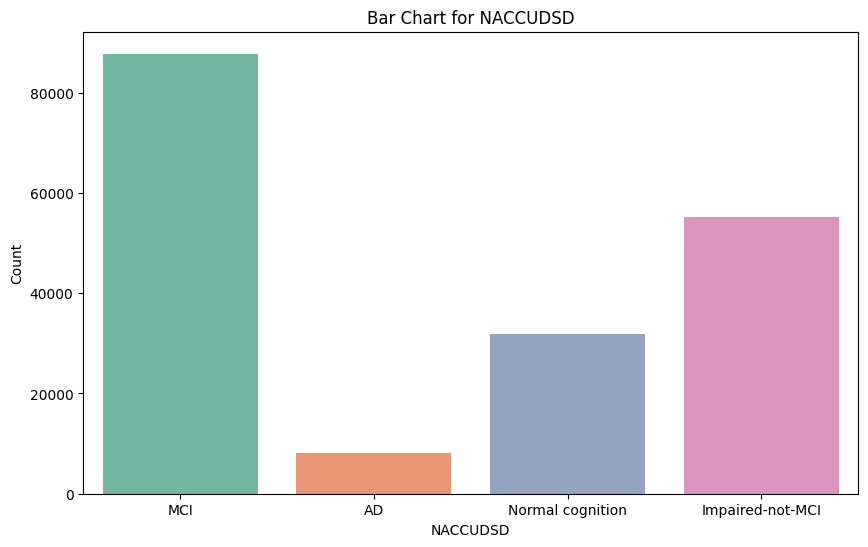

In [ ]:
# visaulising target variable before class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

In [ ]:
# Class balancing
# Assuming you have a DataFrame named 'df' and the target variable is 'NACCUDSD'
# Separate the majority and minority classes
majority_class = df[df['NACCUDSD'] == 0]  # Assuming '2' is the majority class
minority_class_2 = df[df['NACCUDSD'] == 3]
minority_class_1 = df[df['NACCUDSD'] == 2]
minority_class_0 = df[df['NACCUDSD'] == 1]
# Oversample the minority classes to match the size of the majority class
minority_oversampled_2 = minority_class_2.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_1 = minority_class_1.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_0 = minority_class_0.sample(len(majority_class), replace=True, random_state=42)

# Concatenate the majority class with the oversampled minority classes
balanced_df = pd.concat([majority_class, minority_oversampled_2, minority_oversampled_1, minority_oversampled_0])

# Shuffle the DataFrame to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Update the target column name if needed
df = balanced_df

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
2    87792
0    87792
3    87792
1    87792
Name: NACCUDSD, dtype: int64


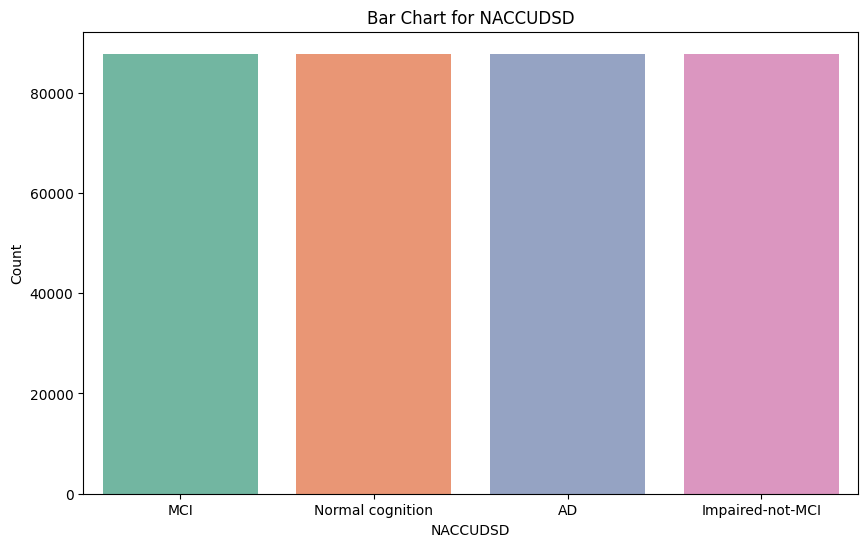

In [ ]:
# Viualising target variable after class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

In [ ]:
# Define the LSTM model
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        # If out is 3D, you can use the last time step's output
        # Otherwise, use the entire sequence (remove the indexing)
        out = self.fc(out[:, -1, :]) if len(out.shape) == 3 else self.fc(out)

        return out

In [ ]:
# Set hyperparameters
input_size = X_train_tensor.shape[1]  # Assuming X_train_tensor has shape (batch_size, sequence_length, num_features)
hidden_size = 256 #was = 64 earlier
num_layers = 4
num_classes = 4

In [ ]:
# Instantiate the model, loss function, and optimizer
model = MyLSTM(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert y_train_tensor to LongTensor (required for CrossEntropyLoss)
y_train_tensor = y_train_tensor.long()

In [ ]:
# Training loop
num_epochs = 10
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        features, labels = batch
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

# Convert y_test_tensor to LongTensor (required for accuracy_score)
y_test_tensor = y_test_tensor.long()

# Calculate and print evaluation metrics
accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
precision = precision_score(y_test_tensor, predicted, average='weighted')
recall = recall_score(y_test_tensor, predicted, average='weighted')
f1 = f1_score(y_test_tensor, predicted, average='weighted')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.8941, Precision: 0.9003, Recall: 0.8941, F1 Score: 0.8849
